In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
allTrain=pd.read_csv('train.csv')
allTrain.isnull().any()

shot_id              False
action_type          False
lat                  False
loc_x                False
loc_y                False
lon                  False
minutes_remaining    False
period               False
playoffs             False
season               False
seconds_remaining    False
shot_distance        False
shot_made_flag        True
shot_zone_area       False
game_date            False
opponent             False
dtype: bool

In [4]:
Traindata=allTrain.copy()
Traindata['shot_made_flag'][Traindata['shot_made_flag'].isnull()]=0.5

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(-50, 900)

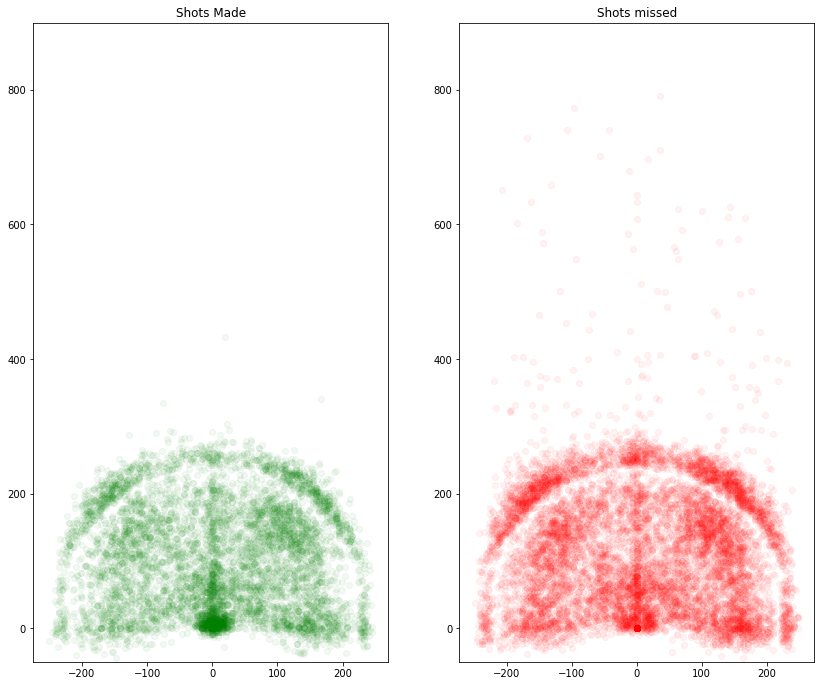

In [4]:
# Court visualization of misses and shots
court_scale, alpha = 7, 0.05
plt.figure(figsize=(2 * court_scale, court_scale*(84.0/50.0)))
# hit
plt.subplot(121)
h = Traindata.loc[Traindata.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='green', alpha=alpha)
plt.title('Shots Made')
ax = plt.gca()
ax.set_ylim([-50, 900])
# miss
plt.subplot(122)
h = Traindata.loc[Traindata.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='red', alpha=alpha)
plt.title('Shots missed')
ax = plt.gca()
ax.set_ylim([-50, 900])


Notice the red dot at where the basket should be? He misses a lot of shots from under the basket. Must be those common ball scenarios.

In [5]:
Traindata['action_type'].unique().shape

(54,)

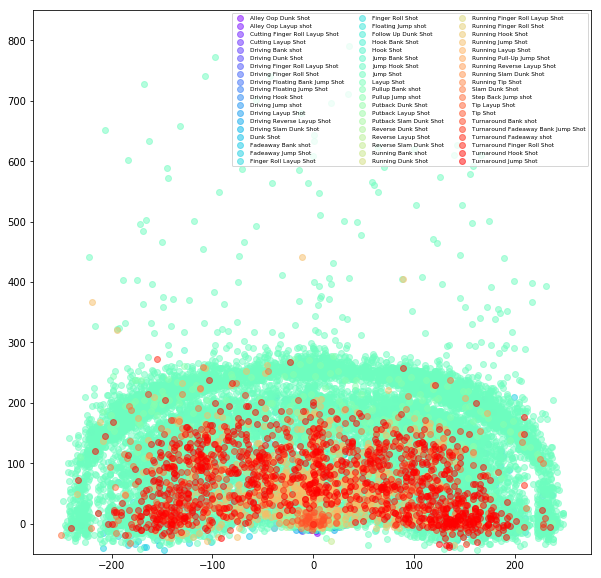

In [4]:
#action type v.s. shot location
import matplotlib.cm as cm
plt.figure(figsize=(10,10))
plt.ylim((-50,850))

def scatter_plot_by_category(data,feat):
    alpha = 0.5
    gs = data.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha,label=g[0])
    
scatter_plot_by_category(Traindata,'action_type')
plt.legend(ncol=3,fontsize='xx-small')


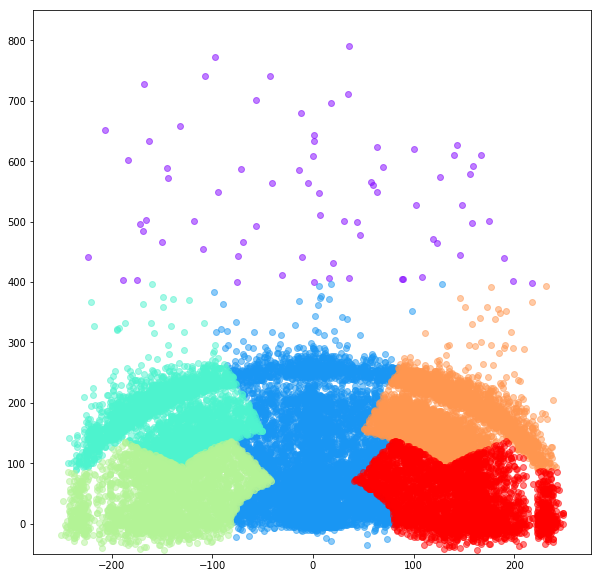

In [45]:
#shot zone area
plt.figure(figsize=(10,10))
plt.ylim((-50,850))
scatter_plot_by_category(Traindata,'shot_zone_area')

In [10]:
sza=Traindata.shot_zone_area.unique()
sza_ind=dict(zip(sza,np.arange(len(sza))))
Traindata['shot_zone_area_ind']=Traindata['shot_zone_area'].map(sza_ind)

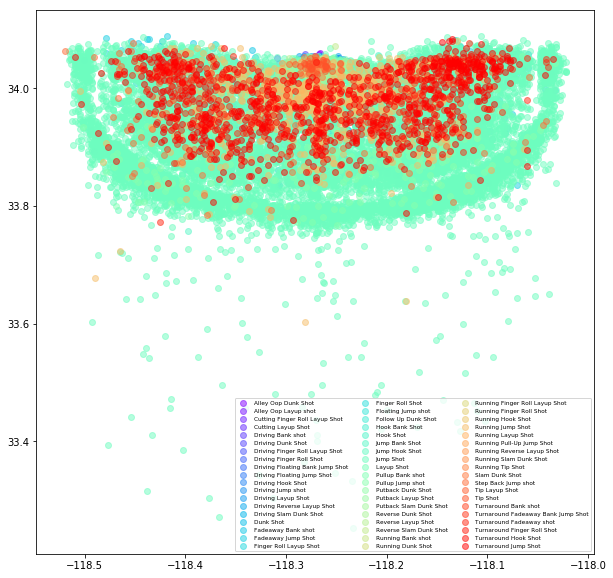

In [24]:
#action_type v.s. shot lon and lat
import matplotlib.cm as cm
plt.figure(figsize=(10,10))

def scatter_plot_by_category_(data,feat):
    alpha = 0.5
    gs = data.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].lon, g[1].lat, color=c, alpha=alpha,label=g[0])
    
scatter_plot_by_category_(Traindata,'action_type')
plt.legend(ncol=3,fontsize='xx-small')

'loc_x','loc_y' and 'lon','lat' can be saied the same, so we can just choose one set of these to be needed features. 

but we still can try "polar coordinate" to place these two sets, because distance and angle may be more representative.

In [79]:
#polar coodinate: angle and dist
Traindata['dist'] = np.sqrt(Traindata['loc_x']**2 + Traindata['loc_y']**2)

loc_x_zero = Traindata['loc_x'] == 0
Traindata['angle'] = np.array([0]*len(Traindata))
Traindata['angle'][~loc_x_zero] = np.arctan(Traindata['loc_y'][~loc_x_zero] / Traindata['loc_x'][~loc_x_zero])
Traindata['angle'][loc_x_zero] = np.pi / 2 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [80]:
#cluster the shot attempts of kobe using GMM on their location
from sklearn import mixture

numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(Traindata.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
Traindata['shotLocationCluster'] = gaussianMixtureModel.predict(Traindata.loc[:,['loc_x','loc_y']])

In [7]:
#Transfer the action types of kobe to integer values
act_type=Traindata.action_type.unique()
act_ind=dict(zip(act_type,np.arange(len(act_type))))
Traindata['act_ind']=Traindata['action_type'].map(act_ind)

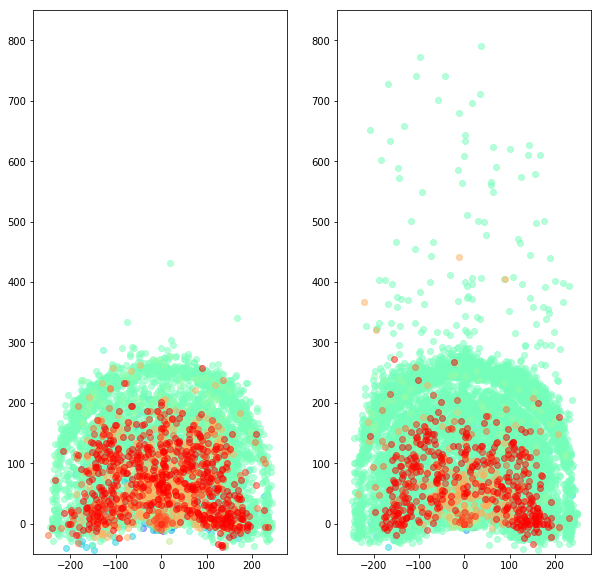

In [12]:
#action type v.s. made or missed
madeit=Traindata[Traindata['shot_made_flag']==1]
not_madeit=Traindata[Traindata['shot_made_flag']==0]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.ylim((-50,850))
scatter_plot_by_category(madeit,'action_type')
plt.subplot(1,2,2)
plt.ylim((-50,850))
scatter_plot_by_category(not_madeit,'action_type')

In [13]:
print('the number of action types that making ball fall in: ',madeit.action_type.unique().shape[0])
print('the number of action types that \'not\' making ball fall in: ',not_madeit.action_type.unique().shape[0])

the number of action types that making ball fall in:  53
the number of action types that 'not' making ball fall in:  47


From above, we can know that action types are different with shot position and related with whether fall in or not.

Therefore, we may need shot_made_flag to be needed features.

In [15]:
Traindata['game_date_DT']=pd.to_datetime(Traindata['game_date'])

In [81]:
Traindata['secondsFromPeriodEnd']   = 60*Traindata['minutes_remaining']+Traindata['seconds_remaining']
Traindata['secondsFromPeriodStart'] = 60*(11-Traindata['minutes_remaining'])+(60-Traindata['seconds_remaining'])
Traindata['secondsFromGameStart']   = (Traindata['period'] <= 4).astype(int)*(Traindata['period']-1)*12*60 + (Traindata['period'] > 4).astype(int)*((Traindata['period']-5)*5*60 + 4*12*60) + Traindata['secondsFromPeriodStart']

Traindata.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,4,4,59,2581
1,3,1,52,2048
2,3,2,5,2035
3,3,8,54,1626
4,4,4,29,2611
5,4,11,46,2174
6,3,10,44,1516
7,4,7,57,2403
8,1,7,53,247
9,4,3,39,2661


In [8]:
Traindata['action_first_words'] = Traindata.action_type.str.split(' ').str[0]
action=Traindata['action_first_words'].unique()

Text(0.5,0,'time [seconds from start of game]')

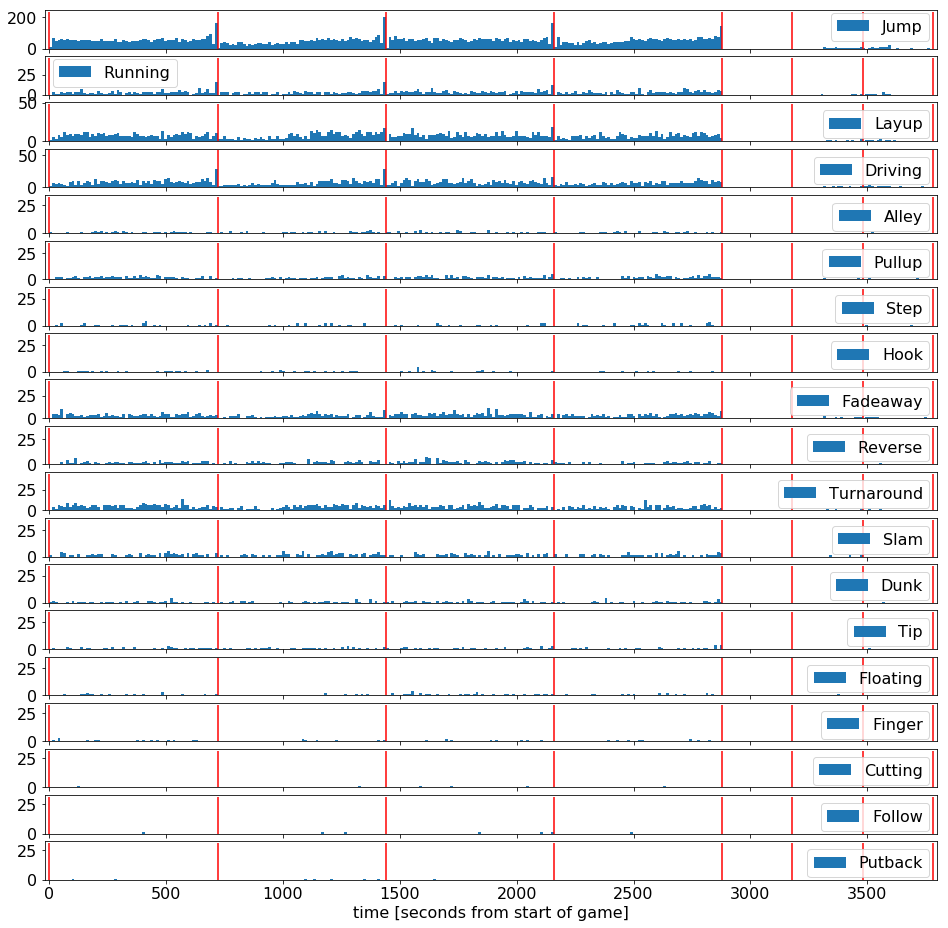

In [16]:
#action type v.s. time from game start
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

binSizes = 12

plt.figure();
for i, act in enumerate(action): 
    timeBins = np.arange(0,60*(4*12+3*5),binSizes)+0.01
    ActTypeAsFunctionOfTime, b = np.histogram(Traindata.loc[Traindata['action_first_words']==act,'secondsFromGameStart'], bins=timeBins)     
    maxHeight = max(ActTypeAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(action),1,i+1); 
    plt.bar(timeBins[:-1],ActTypeAsFunctionOfTime, align='edge', width=barWidth,label=act)
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight,colors='r')
    plt.xlim((-20,3800));
    plt.legend()
plt.xlabel('time [seconds from start of game]')

Kobe likes making some specific action types.

We can see that there are differences in action types with time, for example, some type attempts won't change along time passing but some will, and he likes to make some action type in specific time.

we can know his shot attempts increase a lot when time is about to over, and his action type-time pattern are similar in almost every period of every type besides in the 2nd, 4th and 5th periods (making fewer shots) 

Therefore, we have to put 'secondsFromGameStart' in our needed features.

In [254]:
#Traindata.action_type.value_counts()
#train_label=['Jump Shot','Layup Shot','Driving Layup Shot','']

Jump Shot                             15058
Layup Shot                             2068
Driving Layup Shot                     1579
Fadeaway Jump Shot                      856
Turnaround Jump Shot                    854
Running Jump Shot                       746
Pullup Jump shot                        387
Turnaround Fadeaway shot                343
Slam Dunk Shot                          333
Reverse Layup Shot                      319
Jump Bank Shot                          263
Driving Dunk Shot                       241
Dunk Shot                               211
Tip Shot                                149
Step Back Jump shot                     103
Floating Jump shot                       92
Alley Oop Dunk Shot                      90
Driving Reverse Layup Shot               75
Hook Shot                                70
Driving Finger Roll Shot                 69
Alley Oop Layup shot                     67
Driving Finger Roll Layup Shot           63
Reverse Dunk Shot               

In [5]:
opp=Traindata.opponent.unique()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5,0,'oppenents')

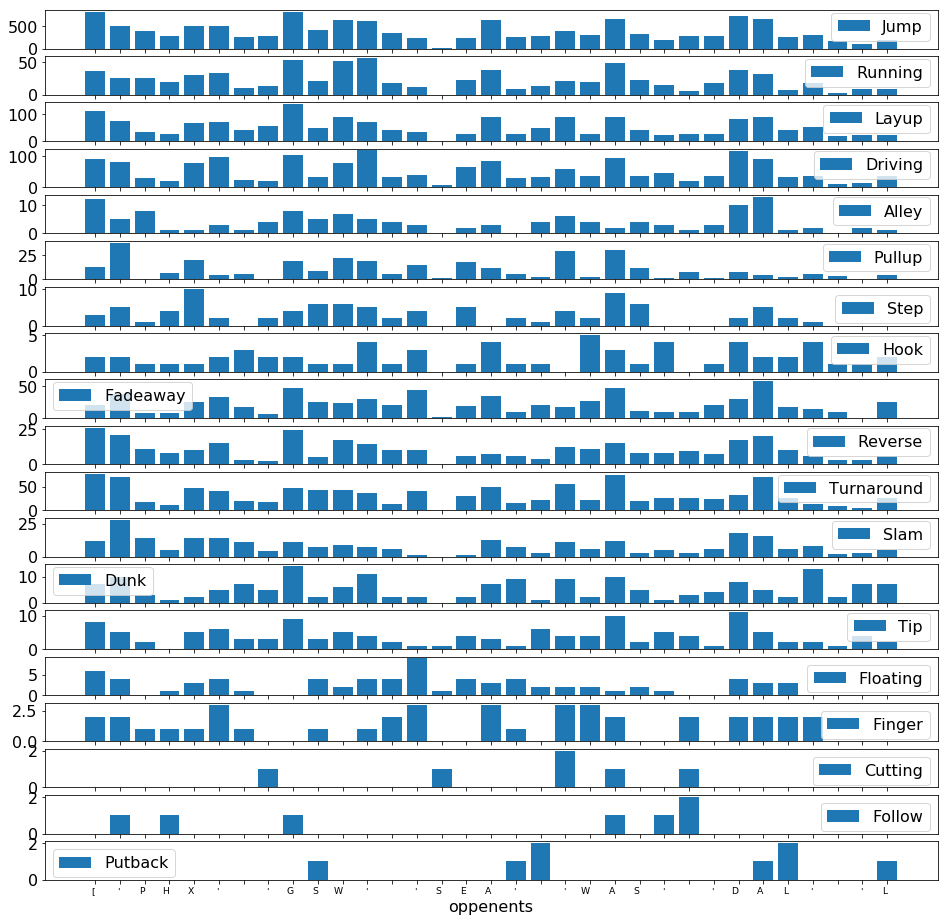

In [18]:
#action type v.s. opponent
plt.figure();
for i,act in enumerate(action):
    ActAttemptsWithOpp=np.zeros((len(opp)))
    for j,op in enumerate(opp):
        ActAttemptsWithOpp[j]=len(Traindata.loc[Traindata['action_first_words']==act][Traindata['opponent']==op])
    plt.subplot(len(action),1,i+1)
    plt.bar(np.arange(len(opp)),ActAttemptsWithOpp,label=act)
    plt.xticks(np.arange(len(opp)), str(opp), ha="right",fontsize='xx-small');
    plt.legend()
plt.xlabel('oppenents')

In [6]:
opp_ind=dict(zip(opp,np.arange(len(opp))))
Traindata['opponent_ind']=Traindata['opponent'].map(opp_ind)

his action types differ with different opponents, so we should put 'opponent' in needed features.

#### test data processing

In [33]:
allTest=pd.read_csv('test.csv')

In [34]:
x_test=allTest.copy()
x_test['shot_made_flag'][x_test['shot_made_flag'].isnull()]=0.5

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
x_test['shot_zone_area_ind']=x_test['shot_zone_area'].map(sza_ind)

In [82]:
x_test['dist'] = np.sqrt(x_test['loc_x']**2 + x_test['loc_y']**2)
loc_x_zero = x_test['loc_x'] == 0
x_test['angle'] = np.array([0]*len(x_test))
x_test['angle'][~loc_x_zero] = np.arctan(x_test['loc_y'][~loc_x_zero] / x_test['loc_x'][~loc_x_zero])
x_test['angle'][loc_x_zero] = np.pi / 2 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [83]:
gaussianMixtureModel.fit(x_test.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
x_test['shotLocationCluster'] = gaussianMixtureModel.predict(x_test.loc[:,['loc_x','loc_y']])

In [37]:
x_test['game_date_DT']=pd.to_datetime(x_test['game_date'])

In [84]:
x_test['secondsFromPeriodEnd']   = 60*x_test['minutes_remaining']+x_test['seconds_remaining']
x_test['secondsFromPeriodStart'] = 60*(11-x_test['minutes_remaining'])+(60-x_test['seconds_remaining'])
x_test['secondsFromGameStart']   = (x_test['period'] <= 4).astype(int)*(x_test['period']-1)*12*60 + (x_test['period'] > 4).astype(int)*((x_test['period']-5)*5*60 + 4*12*60) + x_test['secondsFromPeriodStart']
#x_test.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

In [35]:
x_test['opponent_ind']=x_test['opponent'].map(opp_ind)

In [136]:
Traindata.period.unique()

array([4, 3, 1, 2, 5, 6, 7], dtype=int64)

In [234]:
#y_train=Traindata.action_type
y_train=Traindata.act_ind

In [25]:
label_test=pd.read_csv('type_sample_submission.csv',names=['shot_id','action_type'])

In [235]:
label_test['act_ind']=label_test['action_type'].map(act_ind)
y_test=label_test['act_ind']
#y_test=label_test['action_type']

In [256]:
label=Traindata.action_type.str.split(' ').str[0]
label

0           Jump
1           Jump
2           Jump
3        Running
4           Jump
5           Jump
6           Jump
7           Jump
8           Jump
9          Layup
10          Jump
11         Layup
12       Running
13          Jump
14          Jump
15       Driving
16       Driving
17          Jump
18         Layup
19          Jump
20          Jump
21          Jump
22          Jump
23          Jump
24         Layup
25       Driving
26       Driving
27         Alley
28        Pullup
29         Layup
          ...   
24527    Driving
24528      Layup
24529       Jump
24530      Layup
24531       Jump
24532       Jump
24533    Running
24534      Layup
24535      Layup
24536    Driving
24537       Jump
24538       Jump
24539     Pullup
24540    Driving
24541       Jump
24542       Jump
24543       Dunk
24544       Jump
24545       Jump
24546       Jump
24547       Jump
24548       Jump
24549      Layup
24550       Jump
24551       Jump
24552      Alley
24553       Jump
24554       Ju

In [257]:
label_t=label_test['action_type'].str.split(' ').str[0]

In [76]:
Traindata.columns

Index(['shot_id', 'action_type', 'lat', 'loc_x', 'loc_y', 'lon',
       'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_zone_area', 'game_date', 'shot_zone_basic', 'dist', 'angle',
       'shotLocationCluster', 'act_ind', 'secondsFromPeriodEnd',
       'secondsFromPeriodStart', 'secondsFromGameStart', 'action_first_words',
       'opponent_ATL', 'opponent_BKN', 'opponent_BOS', 'opponent_CHA',
       'opponent_CHI', 'opponent_CLE', 'opponent_DAL', 'opponent_DEN',
       'opponent_DET', 'opponent_GSW', 'opponent_HOU', 'opponent_IND',
       'opponent_LAC', 'opponent_MEM', 'opponent_MIA', 'opponent_MIL',
       'opponent_MIN', 'opponent_NJN', 'opponent_NOH', 'opponent_NOP',
       'opponent_NYK', 'opponent_OKC', 'opponent_ORL', 'opponent_PHI',
       'opponent_PHX', 'opponent_POR', 'opponent_SAC', 'opponent_SAS',
       'opponent_SEA', 'opponent_TOR', 'opponent_UTA', 'opponent_VAN',
       'opponent_WAS'],
  

In [146]:
x_train_1=Traindata.copy()
x_train_1=x_train_1.drop(['action_type', 'shot_id','lat', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words'], axis=1)

x_test_1=x_test.copy()
x_test_1=x_test_1.drop(['shot_id','lat', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd','secondsFromPeriodStart'], axis=1)

In [88]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train_1,y_train)
y_pred_1=LR.predict(x_test_1)
LR.score(x_test_1,y_test)

0.5307817589576547

In [158]:
from sklearn.neighbors import KNeighborsClassifier
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_1,y_train)
KNC.score(x_test_1,y_test)

0.495114006514658

In [159]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=0)
dtc.fit(x_train_1,y_train)
dtc.score(x_test_1,y_test)

0.5299674267100977

In [149]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(criterion='entropy',n_estimators=20,random_state=1,n_jobs=2)
RFC.fit(x_train_1,y_train)
RFC.score(x_test_1,y_test)

0.4755700325732899

In [150]:
RFC=RandomForestClassifier(n_estimators=50)
RFC.fit(x_train_1,y_train)
RFC.score(x_test_1,y_test)

0.47915309446254073

In [181]:
from sklearn.neural_network import MLPClassifier
NNC=MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5,3), random_state=1)
NNC.fit(x_train_1,y_train)
NNC.score(x_test_1,y_test)

0.6224755700325733

In [188]:
from sklearn import svm
SVC=svm.SVC()
SVC.fit(x_train_1,y_train)
SVC.score(x_test_1,y_test)

0.5299674267100977

In [ ]:
SVC_l=svm.SVC(kernel='linear')
SVC_l.fit(x_train_1,y_train)
SVC_l.score(x_test_1,y_test)

In [153]:
 from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
OvO=OneVsOneClassifier(LinearSVC(random_state = 0))
OvO.fit(x_train_1,y_train)
OvO.score(x_test_1,y_test)

0.5239413680781759

In [100]:
x_train_2=Traindata.copy()
x_train_2=x_train_2.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words','shot_zone_area_ind'], axis=1)

x_test_2=x_test.copy()
x_test_2=x_test_2.drop(['shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd','secondsFromPeriodStart','shot_zone_area_ind'], axis=1)

In [101]:
LR.fit(x_train_2,y_train)
y_pred_2=LR.predict(x_test_2)
LR.score(x_test_2,y_test)

0.5936482084690554

In [162]:
for k in [1,5,10,20,30,40,50]:
    knn = KNeighborsClassifier(n_neighbors=k)
    train_score = knn.fit(x_train_2, y_train).\
        score(x_train_2, y_train)
    valid_score = knn.score(x_test_2, y_test)
    print('k: %d, Train/Valid Acc: %.3f/%.3f' %
          (k, train_score, valid_score))

k: 1, Train/Valid Acc: 0.999/0.360
k: 5, Train/Valid Acc: 0.696/0.481
k: 10, Train/Valid Acc: 0.655/0.558
k: 20, Train/Valid Acc: 0.620/0.614
k: 30, Train/Valid Acc: 0.615/0.620
k: 40, Train/Valid Acc: 0.614/0.622
k: 50, Train/Valid Acc: 0.613/0.622


In [163]:
dtc.fit(x_train_2, y_train)
dtc.score(x_test_2,y_test)

0.5299674267100977

In [150]:
RFC.fit(x_train_2,y_train)
RFC.score(x_test_2,y_test)

0.4982084690553746

In [182]:
NNC.fit(x_train_2,y_train)
NNC.score(x_test_2,y_test)

0.6224755700325733

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_component=2)
pca.fit(x_train_2)
x_train_2=pca.transform(x_train_2)
x_test_2=pca.transform(x_test_2)

In [ ]:
from sklearn import svm
from sklearn.model_selection import KFold
cv=KFold(shuffle=True)

from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.001,0.01,0.1,1,10],'gamma':[0.001,0.01,0.1,1]}

grid=GridSearchCV(SVC(),param_grid=param_grid,cv=cv,verbose=3)
grid.fit(x_train_2,y_train)
print(grid.best_score)
print(grid.best_params_)

In [125]:
x_train_3=Traindata.copy()
x_train_3=x_train_3.drop(['action_type', 'shot_id','lat', 'loc_x', 'loc_y', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date',
'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words'], axis=1)

x_test_3=x_test.copy()
x_test_3=x_test_3.drop(['shot_id','lat', 'loc_x', 'loc_y', 'lon','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date',
'secondsFromPeriodEnd','secondsFromPeriodStart'], axis=1)

In [112]:
LR.fit(x_train_3,y_train)
y_pred_3=LR.predict(x_test_3)
LR.score(x_test_3,y_test)

0.49560260586319216

In [126]:
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_3,y_train)
KNC.score(x_test_3,y_test)

0.4995114006514658

In [135]:
dtc.fit(x_train_3, y_train)
dtc.score(x_test_3,y_test)

0.504071661237785

In [154]:
RFC.fit(x_train_3,y_train)
RFC.score(x_test_3,y_test)

0.49104234527687296

In [184]:
NNC.fit(x_train_3,y_train)
NNC.score(x_test_3,y_test)

0.6224755700325733

In [140]:
x_train_4=Traindata.copy()
x_train_4=x_train_4.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words'], axis=1)

x_test_4=x_test.copy()
x_test_4=x_test_4.drop(['shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd','secondsFromPeriodStart'], axis=1)

In [141]:
LR.fit(x_train_4,y_train)
y_pred_4=LR.predict(x_test_4)
LR.score(x_test_4,y_test)

0.49641693811074916

In [142]:
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_4,y_train)
KNC.score(x_test_4,y_test)

0.5100977198697069

In [143]:
dtc.fit(x_train_4, y_train)
dtc.score(x_test_4,y_test)

0.504885993485342

In [153]:
RFC.fit(x_train_4,y_train)
RFC.score(x_test_4,y_test)

0.48241042345276874

In [185]:
NNC.fit(x_train_4,y_train)
NNC.score(x_test_4,y_test)

0.6224755700325733

In [129]:
x_train_5=Traindata.copy()
x_train_5=x_train_5.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining',  'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','action_first_words'], axis=1)

x_test_5=x_test.copy()
x_test_5=x_test_5.drop(['shot_id','loc_x', 'loc_y','minutes_remaining',  'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd'], axis=1)

In [172]:
LR.fit(x_train_5,y_train)
LR.score(x_test_5,y_test) 

0.609771986970684

In [178]:
KNC=KNeighborsClassifier(n_neighbors=40)
KNC.fit(x_train_5,y_train)
KNC.score(x_test_5,y_test)

0.6221498371335505

In [173]:
dtc.fit(x_train_5, y_train)
dtc.score(x_test_5,y_test)

0.5299674267100977

In [174]:
RFC.fit(x_train_5,y_train)
RFC.score(x_test_5,y_test)

0.5086319218241042

In [186]:
NNC.fit(x_train_5,y_train)
NNC.score(x_test_5,y_test)

0.6224755700325733

In [30]:
x_train_2=Traindata.copy()
x_train_2=x_train_2.drop(['action_type', 'shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance','shot_zone_area', 'game_date','dist', 'angle'
,'act_ind','secondsFromPeriodEnd','secondsFromPeriodStart','action_first_words','opponent','shot_zone_area'], axis=1)

x_test_2=x_test.copy()
x_test_2=x_test_2.drop(['shot_id','loc_x', 'loc_y','minutes_remaining', 'period', 'playoffs', 'season','seconds_remaining', 'shot_distance', 'game_date','dist', 'angle'
,'secondsFromPeriodEnd','secondsFromPeriodStart','opponent','shot_zone_area'], axis=1)

In [31]:
from sklearn.neighbors import KNeighborsClassifier
KNC=KNeighborsClassifier(n_neighbors=50)
KNC.fit(x_train_2,y_train)
KNC.score(x_test_2,y_test)

0.6224755700325733

In [32]:
from sklearn.neural_network import MLPClassifier
NNC=MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5,3), random_state=1)
NNC.fit(x_train_2,y_train)
NNC.score(x_test_2,y_test)

0.6224755700325733

In [33]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train_2,y_train)
LR.score(x_test_2,y_test)

0.6074918566775245

In [ ]:
1.全部原本feature

In [49]:
train=Traindata.drop(['shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'opponent_ind', 'shot_zone_area_ind'],
      dtype='object')

In [50]:
test=x_test.drop(['shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'opponent_ind', 'shot_zone_area_ind'],
      dtype='object')

In [51]:
from sklearn.neighbors import KNeighborsClassifier
KNC=KNeighborsClassifier(n_neighbors=50)
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.4998371335504886

In [52]:
train=Traindata.drop(['loc_x', 'loc_y','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_distance', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind'],
      dtype='object')

In [53]:
test=x_test.drop(['loc_x', 'loc_y','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_distance', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind'],
      dtype='object')

In [54]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.49413680781758956

In [55]:
train=Traindata.drop(['lat', 'lon','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_distance', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind'],
      dtype='object')

In [56]:
test=x_test.drop(['lat', 'lon','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_distance', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind'],
      dtype='object')

In [57]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.5

In [58]:
train=Traindata.drop(['lat', 'lon','shot_distance','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind'],
      dtype='object')

In [59]:
test=x_test.drop(['lat', 'lon','shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind'],
      dtype='object')

In [60]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.5001628664495114

In [319]:
train=Traindata.drop(['loc_x', 'loc_y','shot_distance','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'range', 'range_cate'],
      dtype='object')

In [320]:
test=x_test.drop(['loc_x', 'loc_y','shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'range', 'range_cate'],
      dtype='object')

In [321]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.49723127035830617

In [ ]:
only lat,lon better than loc_x,loc_y,shot_distance

In [64]:
train=Traindata.drop(['loc_x', 'loc_y','shot_distance','playoffs','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'seconds_remaining',
       'shot_made_flag', 'opponent_ind', 'shot_zone_area_ind'],
      dtype='object')

In [65]:
test=x_test.drop(['loc_x', 'loc_y','shot_distance','playoffs','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'seconds_remaining',
       'shot_made_flag', 'opponent_ind', 'shot_zone_area_ind'],
      dtype='object')

In [66]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [70]:
train=Traindata.drop(['loc_x', 'loc_y','shot_distance','playoffs', 'shot_zone_area_ind','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'seconds_remaining',
       'shot_made_flag', 'opponent_ind'],
      dtype='object')

In [71]:
test=x_test.drop(['loc_x', 'loc_y','shot_distance','playoffs', 'shot_zone_area_ind','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'seconds_remaining',
       'shot_made_flag', 'opponent_ind'],
      dtype='object')

In [72]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [179]:
train=Traindata.drop(['loc_x', 'loc_y','shot_distance','playoffs', 'shot_zone_area_ind', 'minutes_remaining','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'period', 'seconds_remaining', 'shot_made_flag',
       'opponent_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'range', 'range_cate'],
      dtype='object')

In [180]:
test=x_test.drop(['loc_x', 'loc_y','shot_distance','playoffs', 'shot_zone_area_ind', 'minutes_remaining','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'period', 'seconds_remaining', 'shot_made_flag',
       'opponent_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'range', 'range_cate'],
      dtype='object')

In [181]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.4970684039087948

In [182]:
train=Traindata.drop(['loc_x', 'loc_y','shot_distance','playoffs', 'shot_zone_area_ind', 'seconds_remaining','shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'shot_made_flag',
       'opponent_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'range', 'range_cate'],
      dtype='object')

In [183]:
test=x_test.drop(['loc_x', 'loc_y','shot_distance','playoffs', 'shot_zone_area_ind', 'seconds_remaining','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'shot_made_flag',
       'opponent_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'range', 'range_cate'],
      dtype='object')

In [184]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.4996742671009772

In [ ]:
seconds_remaining better than minutes remaining

In [ ]:
2.包括後來加上的所有feature

In [86]:
train=Traindata.drop(['shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'opponent_ind', 'shot_zone_area_ind', 'dist', 'angle',
       'shotLocationCluster', 'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart'],
      dtype='object')

In [89]:
test=x_test.drop(['shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'opponent_ind', 'shot_zone_area_ind', 'dist', 'angle',
       'shotLocationCluster', 'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart'],
      dtype='object')

In [90]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.49478827361563515

In [91]:
train=Traindata.drop(['loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart'],
      dtype='object')

In [92]:
test=x_test.drop(['loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind', 'dist', 'angle', 'shotLocationCluster',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart'],
      dtype='object')

In [93]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.49723127035830617

In [106]:
train=Traindata.drop(['dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind', 'shotLocationCluster', 'secondsFromPeriodEnd',
       'secondsFromPeriodStart', 'secondsFromGameStart'],
      dtype='object')

In [107]:
test=x_test.drop(['dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shot_zone_area_ind', 'shotLocationCluster', 'secondsFromPeriodEnd',
       'secondsFromPeriodStart', 'secondsFromGameStart'],
      dtype='object')

In [108]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [ ]:
still only lat,lon better than loc_x,loc_y,shot_diatance,dist,angle

In [112]:
train=Traindata.drop(['shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shotLocationCluster', 'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart'],
      dtype='object')

In [113]:
test=x_test.drop(['shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'seconds_remaining', 'shot_made_flag', 'opponent_ind',
       'shotLocationCluster', 'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart'],
      dtype='object')

In [114]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [115]:
train=Traindata.drop(['minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'period', 'seconds_remaining', 'shot_made_flag',
       'opponent_ind', 'shotLocationCluster', 'secondsFromPeriodEnd',
       'secondsFromPeriodStart', 'secondsFromGameStart'],
      dtype='object')

In [116]:
test=x_test.drop(['minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'period', 'seconds_remaining', 'shot_made_flag',
       'opponent_ind', 'shotLocationCluster', 'secondsFromPeriodEnd',
       'secondsFromPeriodStart', 'secondsFromGameStart'],
      dtype='object')

In [117]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [130]:
train=Traindata.drop(['period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'shot_made_flag', 'opponent_ind', 'shotLocationCluster',
       'secondsFromGameStart'],
      dtype='object')

In [131]:
test=x_test.drop(['period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'shot_made_flag', 'opponent_ind', 'shotLocationCluster',
       'secondsFromGameStart'],
      dtype='object')

In [132]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [154]:
Range = []
for i in range(len(Traindata)):
    if Traindata['dist'][i] ==0:
        Range.append(0)
    elif (Traindata['dist'][i] >0)and (Traindata['dist'][i] < 30):
        Range.append(1)
    elif (Traindata['dist'][i] > 30) and (Traindata['dist'][i]<230):
        Range.append(2)
    elif (Traindata['dist'][i] > 230) and (Traindata['dist'][i]<290):
        Range.append(3)
    else:
        Range.append(4)
        
Traindata['range'] = Range
Traindata['range_cate'] = Traindata['range'].astype('category')

#test
test_Range = []
for i in range(len(x_test)):
    if x_test['dist'][i] ==0:
        test_Range = np.append(test_Range,0)
    elif x_test['dist'][i] >0 and x_test['dist'][i] < 31:
        test_Range = np.append(test_Range,1)
    elif x_test['dist'][i] > 30 and x_test['dist'][i]<231:
        test_Range = np.append(test_Range,2)
    elif x_test['dist'][i] > 230 and x_test['dist'][i]<291:
        test_Range = np.append(test_Range,3)
    else:
        test_Range = np.append(test_Range,4)
        
x_test['range'] = test_Range
x_test['range_cate'] = x_test['range'].astype('category')

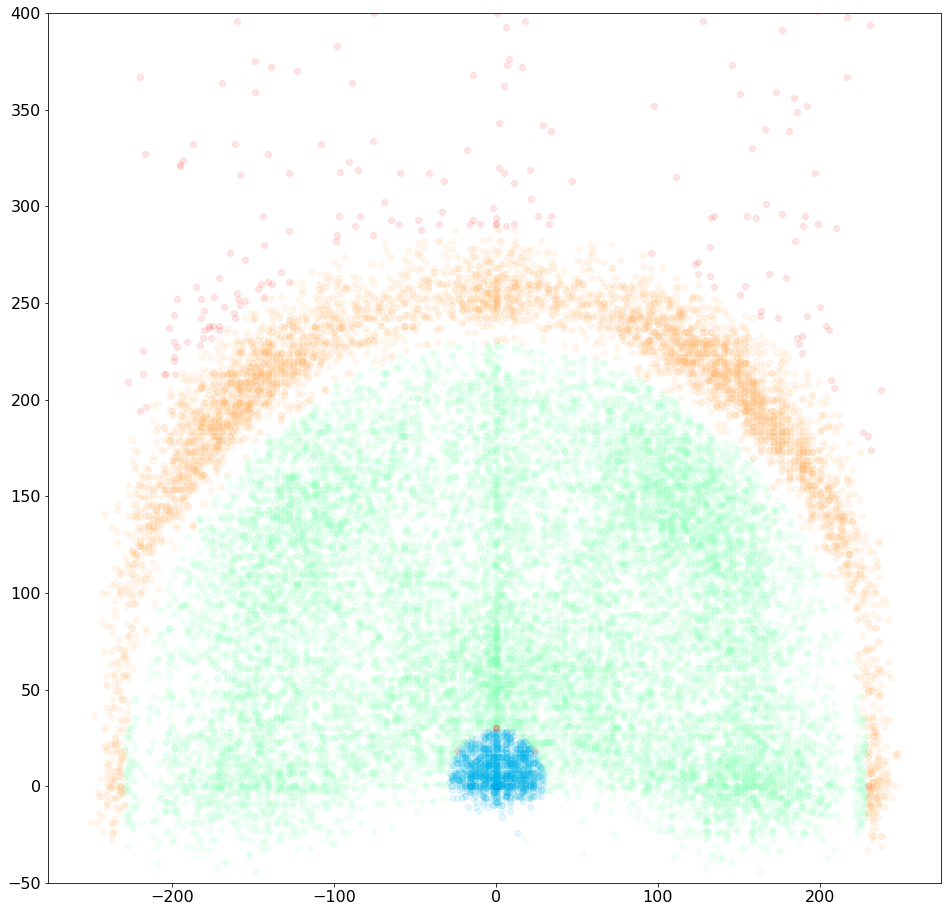

In [157]:
import matplotlib.cm as cm
def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = Traindata.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)
plt.ylim(-50,400)
# shot_zone_area
scatter_plot_by_category('range_cate')

In [161]:
train=Traindata.drop(['range_cate','period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'shot_made_flag', 'opponent_ind', 'shotLocationCluster',
       'secondsFromGameStart', 'range'],
      dtype='object')

In [162]:
test=x_test.drop(['range_cate','period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'shot_made_flag', 'opponent_ind', 'shotLocationCluster',
       'secondsFromGameStart', 'range'],
      dtype='object')

In [163]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [166]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
OvR=OneVsOneClassifier(estimator=SVC(random_state=0))
OvR.fit(train,y_train)
OvR.score(test,y_test)

0.5750814332247557

In [185]:
train=Traindata.drop(['shotLocationCluster','range_cate','period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train.columns

Index(['lat', 'lon', 'shot_made_flag', 'opponent_ind', 'secondsFromGameStart',
       'range'],
      dtype='object')

In [186]:
test=x_test.drop(['shotLocationCluster','range_cate','period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test.columns

Index(['lat', 'lon', 'shot_made_flag', 'opponent_ind', 'secondsFromGameStart',
       'range'],
      dtype='object')

In [187]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.6224755700325733

In [192]:
train=Traindata.drop(['secondsFromGameStart','opponent_ind','lat', 'lon','range_cate','period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','opponent','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train= pd.get_dummies(train, columns=['shot_made_flag', 'shotLocationCluster', 'range'])

In [193]:
test=x_test.drop(['secondsFromGameStart','opponent_ind','lat', 'lon','range_cate','period','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','opponent','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test= pd.get_dummies(test, columns=['shot_made_flag', 'shotLocationCluster', 'range'])

In [194]:
KNC.fit(train,y_train)
KNC.score(test,y_test)

0.5311074918566775

In [195]:
from sklearn.neural_network import MLPClassifier
NNC=MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5,2), random_state=1)
NNC.fit(train,y_train)
NNC.score(test,y_test)

0.504885993485342

In [322]:
train=Traindata.drop(['opponent','lat', 'lon','range_cate','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance', 'shot_id','action_type','shot_zone_area','season', 'game_date','game_date_DT','act_ind'],axis=1)
train= pd.get_dummies(train, columns=['shot_made_flag', 'shotLocationCluster', 'range'])
train.columns

Index(['period', 'opponent_ind', 'secondsFromGameStart', 'shot_made_flag_0.0',
       'shot_made_flag_0.5', 'shot_made_flag_1.0', 'shotLocationCluster_0',
       'shotLocationCluster_1', 'shotLocationCluster_2',
       'shotLocationCluster_3', 'shotLocationCluster_4',
       'shotLocationCluster_5', 'shotLocationCluster_6',
       'shotLocationCluster_7', 'shotLocationCluster_8',
       'shotLocationCluster_9', 'shotLocationCluster_10',
       'shotLocationCluster_11', 'shotLocationCluster_12', 'range_0',
       'range_1', 'range_2', 'range_3', 'range_4'],
      dtype='object')

In [323]:
test=x_test.drop(['opponent','lat', 'lon','range_cate','secondsFromPeriodEnd','secondsFromPeriodStart','seconds_remaining','minutes_remaining', 'playoffs','shot_zone_area_ind','dist', 'angle','loc_x', 'loc_y', 'shot_distance','shot_id','shot_zone_area','season', 'game_date','game_date_DT'],axis=1)
test= pd.get_dummies(test, columns=['shot_made_flag', 'shotLocationCluster', 'range'])

In [350]:
KNC.fit(train,y_train)
y_pred=KNC.predict(test)
KNC.score(test,y_test)

0.6224755700325733

In [261]:
KNC.fit(train,label)
KNC.score(test,label_t)

0.6348534201954398

In [273]:
y_train_str=Traindata.action_type
y_test_str=label_test['action_type']

In [326]:
KNC.fit(train,y_train_str)
y_pred=KNC.predict(test)
KNC.score(test,y_test_str)

0.6224755700325733

In [327]:
y_pred

array(['Jump Shot', 'Jump Shot', 'Jump Shot', ..., 'Jump Shot',
       'Jump Shot', 'Jump Shot'], dtype=object)

In [325]:
NNC=MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5,2), random_state=1)
NNC.fit(train,y_train)
NNC.score(test,y_test)

0.6224755700325733

In [282]:
y_pred=NNC.predict(test)

In [284]:
np.mean(y_pred)

0.0

In [285]:
NNC.fit(train,label)
NNC.score(test,label_t)

0.6348534201954398

In [286]:
y_pred=NNC.predict(test)

In [289]:
np.mean(y_pred!='Jump')

0.0

In [237]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
clfpipe = Pipeline([('scl', StandardScaler()),
                ('pca', PCA()),
                ('clf', MLPRegressor(hidden_layer_sizes = 10, batch_size = 32, learning_rate = 'adaptive'))])

clfpipe.fit(train, y_train)
clfpipe.score

<function sklearn.pipeline.Pipeline.score>

In [333]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=0)
dtc.fit(train,y_train)
dtc.score(test,y_test)

0.5043973941368078

In [351]:
KNC.score(train,y_train)

0.6131856497129128

In [348]:
np.mean(y_train==0)

0.6131856497129128

In [353]:
np.mean(Traindata['action_type']=='Jump Shot')

0.6131856497129128

In [240]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier()
clftree = clftree.fit(train, y_train)
clftree.score(test,y_test)

0.35863192182410425

In [241]:
f=pd.read_csv('predict_nn4.csv')
f.head()

,Unnamed: 0,0,1
0,0,25205,Jump Shot
1,1,10194,Jump Shot
2,2,4580,Layup Shot
3,3,15269,Driving Layup Shot
4,4,2859,Jump Shot


In [248]:
np.mean(f['1']==label_test['action_type'])

0.5029315960912052

In [292]:
f=pd.read_csv('predict_t.csv')
f.head()

,Unnamed: 0,0,1
0,0,25205,Jump Shot
1,1,10194,Jump Shot
2,2,4580,Layup Shot
3,3,15269,Layup Shot
4,4,2859,Jump Shot


In [293]:
np.mean(f['1']==label_test['action_type'])

0.5030944625407167

In [330]:
np.mean(label_t==f['1'].str.split(' ').str[0])

0.5151465798045602

In [317]:
Traindata.action_type.str.split(' ').str[0].unique()

array(['Jump', 'Running', 'Layup', 'Driving', 'Alley', 'Pullup', 'Step',
       'Hook', 'Fadeaway', 'Reverse', 'Turnaround', 'Slam', 'Dunk', 'Tip',
       'Floating', 'Finger', 'Cutting', 'Follow', 'Putback'], dtype=object)

In [331]:
np.mean(f['1']==y_pred)

0.7773615635179153

In [366]:
from IPython.display import Image
import pydotplus 
dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=train.columns,  
                         class_names=Traindata.action_type,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

InvocationException: GraphViz's executables not found

In [365]:
import os

# 导入路径
os.environ["path"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'